In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt

In [3]:
k = 0.1  # 前视距离系数
Lfc = 0.1  # 前视距离
Kp = 1.0  # 速度P控制器系数
dt = 0.1  # 时间间隔，单位：s
L = 0.6 # 车辆轴距，单位：m

In [13]:
class VehicleState:
 
    def __init__(self, x=0.0, y=0.0, yaw=0.0, v=0.0):
        self.x = x
        self.y = y
        self.yaw = yaw
        self.v = v
 
 
def update(state, a, delta):
 
    state.x = state.x + state.v * math.cos(state.yaw) * dt
    state.y = state.y + state.v * math.sin(state.yaw) * dt
    state.yaw = state.yaw + state.v / L * math.tan(delta) * dt
    state.v = state.v + a * dt
 
    return state

def PIDControl(target, current):
    a = Kp * (target - current)
    return a

In [8]:
def pure_pursuit_control(state, cx, cy, pind):   
    ind = calc_target_index(state, cx, cy)        #搜寻最近的点 ind
    '''
    # 每次运行 pure pursuit control时
    # 首选从路径中选择一个最近的点
    # 再从这个点展开，寻找一个长度为前视距离的点；
    # 然后计算 转向角δ；
    '''

    if pind >= ind:                        
        ind = pind
    '''
     # 如果初始目标点序号在搜索的点后，直接更新当前搜索点的序号为初始序号
     # 在经历初次之后，把当前点赋予作为下一个目标点标志；
    '''

    if ind < len(cx):        #若目标点没有超过范围，去具体坐标赋予 tx，ty用作目标
        tx = cx[ind]
        ty = cy[ind]
    else:                    #若超过了，把最后一个点赋给目标
        tx = cx[-1]
        ty = cy[-1]
        ind = len(cx) - 1
    alpha = math.atan2(ty - state.y, tx - state.x) - state.yaw      #计算当前点到目标点的方向角差
    if state.v < 0:  # back
        alpha = math.pi - alpha

    Lf = k * state.v + Lfc                                       #前视距离

    # 前视距离的选取与速度有关，也与单位时间距离有关


    delta = math.atan2(2.0 * L * math.sin(alpha) / Lf, 1.0)      #计算转向角
    return delta, ind

In [7]:
def calc_target_index(state, cx, cy):
    # 搜索最临近的路点
    dx = [state.x - icx for icx in cx]
    dy = [state.y - icy for icy in cy]
    d = [abs(math.sqrt(idx ** 2 + idy ** 2)) for (idx, idy) in zip(dx, dy)]
    ind = d.index(min(d))     # 找出最小的d所在的位置
    J = 0.0
    Lf = k * state.v + Lfc
    '''
    首先从目标点中找到一个离当前点最近的点
    然后计算离这个点距离满足前视距离的下一个点
    当两点之间的距离小于前视距离，需要累加几个点直至距离超过前视距离
      
    
    # search look ahead target point index
    # 解读：从path point 接下来中找到 离当前点最接近于 前视距离的一个点
    # 当路径中的下一个点离当前很远时，这里保证了目标点至少下移一个点，不会停留在原地  
    '''
    while Lf > J and (ind + 1) < len(cx):    
        dx = cx[ind + 1] - cx[ind]
        dy = cy[ind + 1] - cy[ind]
        J += math.sqrt(dx ** 2 + dy ** 2)   
        ind += 1
    return ind

In [18]:
def main():
    #  设置目标路点
    cx = [0.76, 1.52, 2.28, 3.04, 3.81, 4.57, 5.33, 5.44, 5.64, 5.66, 5.33, 5.30, 4.39, 4.55, 5.33, 6.33, 6.90, 6.55, 5.33, 3.89, 3.13, 3.66, 5.33, 7.22, 8.16, 7.44, 5.33, 3.00]
    cy = [0.52, 1.04, 1.57, 2.09, 2.61, 3.14, 3.66, 3.77, 3.66, 3.33, 3.03, 3.03, 3.66, 4.44, 4.92, 4.66, 3.66, 2.44, 1.78, 2.22, 3.66, 5.33, 6.18, 5.55, 3.66, 1.55, 0.52, 1.33]
    
 
    target_speed = 2.0 / 3.6  # [m/s]
 
    T = 100.0  # 最大模拟时间
 
    # 设置车辆的出事状态
    state = VehicleState(x=-0.0, y=-3.0, yaw=0.0, v=2.0)
 
    lastIndex = len(cx) - 1
    time = 0.0
    x = [state.x]
    y = [state.y]
    yaw = [state.yaw]
    v = [state.v]
    t = [0.0]
    target_ind = calc_target_index(state, cx, cy)
 
    while T >= time and lastIndex > target_ind:
        ai = PIDControl(target_speed, state.v)
        di, target_ind = pure_pursuit_control(state, cx, cy, target_ind)
        state = update(state, ai, di)
 
        time = time + dt
 
        x.append(state.x)
        y.append(state.y)
        yaw.append(state.yaw)
        v.append(state.v)
        t.append(time)
        
#         plt.cla()
        plt.plot(cx, cy, ".r", label="course")
        plt.plot(x, y, "-b", label="trajectory")
        plt.plot(cx[target_ind], cy[target_ind], "go", label="target")
#         plt.axis("equal")
#         plt.grid(True)
#         plt.title("Speed[km/h]:" + str(state.v * 3.6)[:4])
#         plt.pause(0.001)
 

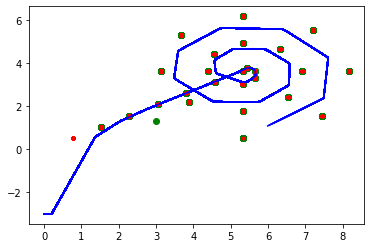

In [19]:
main()


Reference:  
https://www.ri.cmu.edu/pub_files/pub3/coulter_r_craig_1992_1/coulter_r_craig_1992_1.pdf#:~:text=The%20implementation%20of%20the%20pure%20pursuit%20algorithm%20itself,point%20Transform%20the%20goal%20pohl%20to%20vehicle%20coordinates.

In [21]:
np.cos(np.pi * 2)

1.0